# This notebook was adapted from this [repo](https://github.com/seva100/optic-nerve-cnn) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%load_ext autoreload
%autoreload 2
!module load cuda-11.2
!pip install mahotas

import os
import glob
from datetime import datetime
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from skimage.exposure import equalize_adapthist
from tqdm import tqdm_notebook
from IPython.display import display
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transf
from keras.preprocessing.image import img_to_array
import cv2

Mounted at /content/drive


In [ ]:
!unzip -q './drive/MyDrive/airogs/train_512_0.zip'
!unzip -q './drive/MyDrive/airogs/train_512_1.zip'
!unzip -q './drive/MyDrive/airogs/train_512_2.zip'
!unzip -q './drive/MyDrive/airogs/train_512_3.zip'
!unzip -q './drive/MyDrive/airogs/train_512_4.zip'
!unzip -q './drive/MyDrive/airogs/train_512_5.zip'

replace train_512/0/TRAIN003661.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace train_512/1/TRAIN029371.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train_512/2/TRAIN052801.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train_512/3/TRAIN064308.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train_512/4/TRAIN088023.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train_512/5/TRAIN091793.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Training of modified U-Net for Optic Disc on RIM-ONE v3 database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/03.03,14:19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [ ]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.8.0
TensorFlow version: 2.8.0


In [ ]:
K.set_image_data_format('channels_first')

In [ ]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

### U-Net architecture

In [ ]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input(( 3,img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
model = get_unet_light(img_rows=256, img_cols=256)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 32, 256, 256  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 32, 256, 256  0           ['conv2d_38[0][0]']              
                                )                                                           

#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

### Loading model

### Let's start by testing on a single image

In [ ]:
img_path = "/content/train_512/5/TRAIN096878.jpg"
img = Image.open(img_path).convert('RGB')
img = np.array(img)
t = transf.Compose([
    transf.ToTensor(),
    transf.Resize([256,256])
])
img = t(img)

In [ ]:
img_k = tf.keras.preprocessing.image.load_img(
    img_path, grayscale=False, color_mode="rgb", target_size=(256,256), interpolation="nearest"
)
img_k  = img_to_array(img_k)
img_k = img_k.astype(np.float64) / 255.0
img_k = np.expand_dims(a=img_k,axis=0)
img_k.shape

(1, 1, 256, 256)


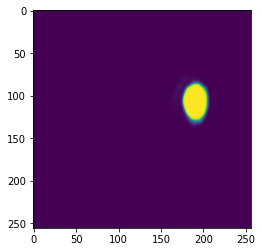

In [ ]:
with tf.device('/GPU:0'):
    model = get_unet_light(img_rows=256, img_cols=256)
    model.load_weights('/content/drive/MyDrive/airogs/last_checkpoint.hdf5') # you can download the checkpoint file from the original repo(https://github.com/seva100/optic-nerve-cnn)
    mask = model.predict(img_k)
    print(mask.shape)

    plt.imshow(mask[0, 0])
    plt.show()

/content/train_512/5/TRAIN096878.jpg
(512, 512, 3)
(256, 256, 3)


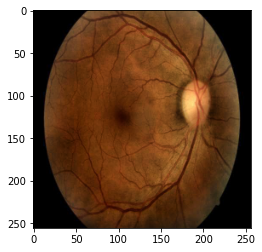

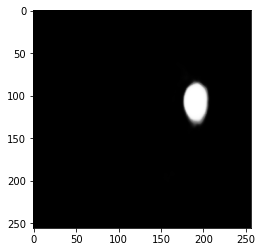

(256, 256)

In [ ]:
print(img_path)
im = np.array(Image.open(img_path))

#Image
im = cv2.resize(im, (256,256))
im = im.astype(np.float64) / 255.0
im = skimage.exposure.equalize_adapthist(im)
plt.imshow(im), plt.show()

#Predicted Image
im = np.expand_dims(im, axis=0)
im = tf_to_th_encoding(im)
OwnPred = (model.predict(im)[0, 0]).astype(np.float64)
plt.imshow(OwnPred, cmap=plt.cm.Greys_r), plt.show()
OwnPred.shape

In [ ]:
mask = torch.Tensor(OwnPred)
mask[mask > 0.35] = 1.0
mask[mask <= 0.35] = 0.0


tensor(1.)
tensor(0.)
tensor([0., 1.])


In [ ]:
from imgaug.augmenters.meta import Augmenter
from torchvision.ops import masks_to_boxes
from imgaug.augmentables.bbs import BoundingBoxesOnImage
from imgaug import augmenters as iaa

# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]


boxes = masks_to_boxes(masks)
print(boxes.shape)
print(boxes)

pad_x = (boxes[0][2] - boxes[0][0]) * 0.3
pad_y = (boxes[0][3] - boxes[0][1]) * 0.3

pad = max(pad_x, pad_y)
pad = max(pad, 20)
print(pad)

x1 = max(0, boxes[0][0] - pad)
x2 = min(255, boxes[0][2] + pad)
y1 = max(0, boxes[0][1] - pad)
y2 = min(255, boxes[0][3] + pad)


boxes = [[x1, y1, x2, y2]]
print(boxes)
boxes = torch.Tensor(boxes)
boxes.shape

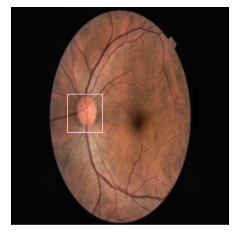

In [ ]:
from torchvision.utils import draw_bounding_boxes
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap="gray")
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


drawn_boxes = draw_bounding_boxes(torch.Tensor(im[0] * 255).type(torch.ByteTensor), boxes, colors="pink")
show(drawn_boxes)

### Now, we can apply this algorithm to the entire dataset

In [ ]:
import glob
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torchvision.transforms.functional as F
import torchvision.transforms as transforms

train_csv = pd.read_csv("/content/drive/MyDrive/airogs/train.csv")
val_csv = pd.read_csv("/content/drive/MyDrive/airogs/val.csv")


no_bounding = 0
with_bounding = 0


train_csv["x1"] = None
train_csv["y1"] = None
train_csv["x2"] = None
train_csv["y2"] = None
val_csv["x1"] = None
val_csv["y1"] = None
val_csv["x2"] = None
val_csv["y2"] = None

def show(imgs, title):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img), cmap="gray")
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[0, i].set_title(title)

def crop_image_only_outside(img,tol=20):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img > tol
    if img.ndim == 3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start, col_end = mask0.argmax(), n - mask0[::-1].argmax()
    row_start, row_end = mask1.argmax(), m - mask1[::-1].argmax()
    
    return img[row_start : row_end, col_start : col_end]

for i, row in tqdm(train_csv.iterrows(), total=train_csv.shape[0]):
  _img_path = glob.glob("/content/train_512/*/" + row["challenge_id"] + ".jpg")
  if len(_img_path) == 0:
    continue
    
  im = np.array(Image.open(_img_path[0]))

  #Image
  im = cv2.resize(im, (256,256))
  im = im.astype(np.float64) / 255.0
  im = skimage.exposure.equalize_adapthist(im)


  #Predicted Image
  im = np.expand_dims(im, axis=0)
  im = tf_to_th_encoding(im)
  OwnPred = (model.predict(im)[0, 0]).astype(np.float64)

  mask = torch.Tensor(OwnPred)
  mask[mask > 0.35] = 1.0
  mask[mask <= 0.35] = 0.0

  # We get the unique colors, as these would be the object ids.
  obj_ids = torch.unique(mask)

  # first id is the background, so remove it.
  obj_ids = obj_ids[1:]

  # split the color-encoded mask into a set of boolean masks.
  # Note that this snippet would work as well if the masks were float values instead of ints.
  masks = mask == obj_ids[:, None, None]

  boxes = masks_to_boxes(masks)


  if boxes.shape[0] == 1:
    pad_x = (boxes[0][2] - boxes[0][0]) * 0.3
    pad_y = (boxes[0][3] - boxes[0][1]) * 0.3

    pad = max(pad_x, pad_y)
    pad = max(pad, 20)

    x1 = max(torch.tensor(0), boxes[0][0] - pad)
    x2 = min(torch.tensor(255), boxes[0][2] + pad)
    y1 = max(torch.tensor(0), boxes[0][1] - pad)
    y2 = min(torch.tensor(255), boxes[0][3] + pad)


    boxes = [[x1, y1, x2, y2]]
    boxes = torch.Tensor(boxes)

    width = abs(boxes[0][2] - boxes[0][0])
    height = abs(boxes[0][3] - boxes[0][1])
    
    bb_area = width * height
    o_area = im.shape[2] * im.shape[2]


  if boxes.shape[0] == 1 and (abs(bb_area - o_area) > (0.65 * o_area)):

    ASSETS_DIRECTORY = "assets"

    plt.rcParams["savefig.bbox"] = "tight"

    with_bounding += 1

    train_csv.loc[i, "x1"] = x1.item()
    train_csv.loc[i, "y1"] = y1.item()
    train_csv.loc[i, "x2"] = x2.item()
    train_csv.loc[i, "y2"] = y2.item()

  else:
    transform = transforms.Compose([
      transforms.ToTensor(),                              
      transforms.CenterCrop(148)
    ])
    _img = transform(np.moveaxis(im[0], 0, -1))


    no_bounding += 1

    train_csv.loc[i, "x1"] = -1
    train_csv.loc[i, "y1"] = -1
    train_csv.loc[i, "x2"] = -1
    train_csv.loc[i, "y2"] = -1


print(f"With Bounding count: {with_bounding}")
print(f"No Bounding count: {no_bounding}")

100%|██████████| 81154/81154 [2:32:07<00:00,  8.89it/s]

With Bounding count: 65671
No Bounding count: 15483


In [ ]:
train_csv.to_csv("/content/drive/MyDrive/airogs/train_256_bbs_final.csv", index=False)